# <font color=blue>Import  

In [1]:
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from pickle import dump
from pickle import load

# <font color=blue>Read  

In [2]:
df_1 = pd.read_csv('data.csv')
df_1.shape

(1177, 51)

# <font color=blue>Format column names  

In [3]:
df_1.columns = df_1.columns.str.lower()
df_1.columns = df_1.columns.str.replace(" ", "_")

# <font color=blue>Use statistically significant features from Logistic Regression with Regularisation model  

In [4]:
df_1 = df_1[['renal_failure', 'bicarbonate', 'blood_calcium', 'urine_output', 'deficiencyanemias',
             'sp_o2', 'heart_rate', 'leucocyte', 'atrialfibrillation', 'urea_nitrogen',
             'outcome']]
df_1.shape

(1177, 11)

# <font color=blue>Drop missing values in outcome (target)  

In [5]:
df_1.dropna(subset=['outcome'], inplace=True)
df_1.shape

(1176, 11)

# <font color=blue>Form X and y  

In [6]:
X = df_1.drop(columns=['outcome'])
print('X :', X.shape)

y = df_1['outcome']
print('y :', y.shape)
print('')

print('y :', np.unique(y, return_counts=True))
print('y :', Counter(y))
print(y.value_counts(normalize=True))

X : (1176, 10)
y : (1176,)

y : (array([0., 1.]), array([1017,  159], dtype=int64))
y : Counter({0.0: 1017, 1.0: 159})
0.0    0.864796
1.0    0.135204
Name: outcome, dtype: float64


# <font color=blue>Function to impute  

In [7]:
# ---------- this function is to retain the column names of dataframe after missing values imputation ----------

def impute_fit_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.fit_transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute, to_impute_fit_transform

def impute_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute

# <font color=blue>Function to scale  

In [8]:
# ---------- this function is to retain the column names of dataframe after scaling ----------

def scale_fit_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.fit_transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale, to_scale_fit_transform

def scale_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale

# <font color=blue>Do 10 x 15-fold cross validation to establish performance of Logistic Regression with Regularisation model using statistically significant features  

In [9]:
train_accuracy = []
train_recall = []
train_precision = []

validate_accuracy = []
validate_recall = []
validate_precision = []

# ---------- use best parameters and hyperparameters determined in code 4b ----------

decision_boundary = 0.35
oversample = 0.85
reg_alpha = 0

loop_count = 0

for rand_state in [12, 22, 32, 42, 52, 62, 72, 82, 92, 102]:
    
    cross_validate = StratifiedKFold(n_splits=15, shuffle=True, random_state=rand_state)
    
    for train_index, validate_index in cross_validate.split(X, y):
        
        # ---------- get train and validate indices ----------
        
        X_train, X_validate = X.iloc[train_index, :], X.iloc[validate_index, :]
        y_train, y_validate = y.iloc[train_index], y.iloc[validate_index]
        
        loop_count = loop_count + 1
        
        print('---------- random state =', rand_state, ' loop =', loop_count, ' ----------')
        print('')
        print('Before y_train:', Counter(y_train))
        print('Before y_validate:', Counter(y_validate))
        print('')
        
        # ---------- impute on train ----------
        
        knn_impute = KNNImputer(n_neighbors=5)
        X_train_impute, knn_impute_fit_transform = impute_fit_transform(X_train, knn_impute)
        
        # ---------- oversample on train ----------
        
        o_s = SMOTE(random_state=42, sampling_strategy=oversample)
        X_train_impute_over, y_train_over = o_s.fit_resample(X_train_impute, y_train.ravel())
        
        print('Before_Over y_train:', Counter(y_train_over))
        print('')
        
        # ---------- scale on train ----------
        
        ss = StandardScaler()
        X_train_impute_over_scale, ss_fit_transform = scale_fit_transform(X_train_impute_over, ss)
        
        # ---------- instantiate and fit regularized on train ----------
        
        X_train_impute_over_scale_const = sm.add_constant(X_train_impute_over_scale)
        lr = sm.Logit(y_train_over, X_train_impute_over_scale_const)
        lr_result = lr.fit_regularized(maxiter=500, method='l1', alpha=reg_alpha)
        print('')
        
        # ---------- impute and scale on train ----------
        # ---------- not using oversample to have fair comparison to validate performance ----------
        
        X_train_impute = impute_transform(X_train, knn_impute_fit_transform)
        X_train_impute_scale = scale_transform(X_train_impute, ss_fit_transform)
        
        # ---------- predict and evaluate on train ----------
        
        X_train_impute_scale_const = sm.add_constant(X_train_impute_scale)
        y_train_predicted = (lr_result.predict(X_train_impute_scale_const)>=decision_boundary).astype(int)
        
        train_accuracy.append(accuracy_score(y_train, y_train_predicted))
        train_recall.append(recall_score(y_train, y_train_predicted))
        train_precision.append(precision_score(y_train, y_train_predicted))
        
        # ---------- impute and scale on validate ----------
        
        X_validate_impute = impute_transform(X_validate, knn_impute_fit_transform)
        X_validate_impute_scale = scale_transform(X_validate_impute, ss_fit_transform)
        
        # ---------- predict and evaluate on validate ----------
        
        X_validate_impute_scale_const = sm.add_constant(X_validate_impute_scale)
        y_validate_predicted = (lr_result.predict(X_validate_impute_scale_const)>=decision_boundary).astype(int)
        
        validate_accuracy.append(accuracy_score(y_validate, y_validate_predicted))
        validate_recall.append(recall_score(y_validate, y_validate_predicted))
        validate_precision.append(precision_score(y_validate, y_validate_predicted))
        
    loop_count = 0

---------- random state = 12  loop = 1  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49722994362950496
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27

---------- random state = 12  loop = 2  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4872952727985838
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28

---------- random state = 12  loop = 3  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 


---------- random state = 22  loop = 7  ----------

Before y_train: Counter({0.0: 949, 1.0: 149})
Before y_validate: Counter({0.0: 68, 1.0: 10})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4969116393788747
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26

---------- random state = 22  loop = 8  ----------

Before y_train: Counter({0.0: 949, 1.0: 149})
Before y_validate: Counter({0.0: 68, 1.0: 10})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48872830788906
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28

---------- random state = 22  loop = 9  ----------

Before y_train: Counter({0.0: 949, 1.0: 149})
Before y_validate: Counter({0.0: 68, 1.0: 10})

Before_Over y_train: Counter({0.0: 94


---------- random state = 32  loop = 13  ----------

Before y_train: Counter({0.0: 950, 1.0: 148})
Before y_validate: Counter({0.0: 67, 1.0: 11})

Before_Over y_train: Counter({0.0: 950, 1.0: 807})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47309299440978186
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27

---------- random state = 32  loop = 14  ----------

Before y_train: Counter({0.0: 950, 1.0: 148})
Before y_validate: Counter({0.0: 67, 1.0: 11})

Before_Over y_train: Counter({0.0: 950, 1.0: 807})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4770159211923921
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31

---------- random state = 32  loop = 15  ----------

Before y_train: Counter({0.0: 950, 1.0: 148})
Before y_validate: Counter({0.0: 67, 1.0: 11})

Before_Over y_train: Counter({0


---------- random state = 52  loop = 3  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49344841522325894
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27

---------- random state = 52  loop = 4  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48262293562539355
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28

---------- random state = 52  loop = 5  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.481415923835813
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27

---------- random state = 62  loop = 11  ----------

Before y_train: Counter({0.0: 949, 1.0: 149})
Before y_validate: Counter({0.0: 68, 1.0: 10})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49863844680150055
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26

---------- random state = 62  loop = 12  ----------

Before y_train: Counter({0.0: 949, 1.0: 149})
Before y_validate: Counter({0.0: 68, 1.0: 10})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5043041937700983
            Iterations: 27
            Function evaluations: 27
       


---------- random state = 82  loop = 4  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4936240271911497
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27

---------- random state = 82  loop = 5  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49320046647752086
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27

---------- random state = 82  loop = 6  ----------

Before y_train: Counter({0.0: 949, 1.0: 148})
Before y_validate: Counter({0.0: 68, 1.0: 11})

Before_Over y_train: Counter({0.0:

Before_Over y_train: Counter({0.0: 949, 1.0: 806})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4885348416777633
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30

---------- random state = 92  loop = 13  ----------

Before y_train: Counter({0.0: 950, 1.0: 148})
Before y_validate: Counter({0.0: 67, 1.0: 11})

Before_Over y_train: Counter({0.0: 950, 1.0: 807})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49369413996176026
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27

---------- random state = 92  loop = 14  ----------

Before y_train: Counter({0.0: 950, 1.0: 148})
Before y_validate: Counter({0.0: 67, 1.0: 11})

Before_Over y_train: Counter({0.0: 950, 1.0: 807})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4989958957180725
            Iterat

# <font color=blue>Accuracy  

In [10]:
temp_df = zip(train_accuracy, validate_accuracy)
temp_df = pd.DataFrame(temp_df, columns=['train_accuracy', 'validate_accuracy'])
temp_df['overfit_%'] = (temp_df['validate_accuracy']-temp_df['train_accuracy'])/temp_df['train_accuracy']*100
temp_df

,train_accuracy,validate_accuracy,overfit_%
0,0.674567,0.696203,3.207321
1,0.689152,0.696203,1.023039
2,0.668186,0.784810,17.453848
3,0.687329,0.632911,-7.917268
4,0.700091,0.582278,-16.828191
...,...,...,...
145,0.682149,0.666667,-2.269693
146,0.678506,0.641026,-5.524006
147,0.670310,0.756410,12.844900
148,0.680328,0.666667,-2.008032


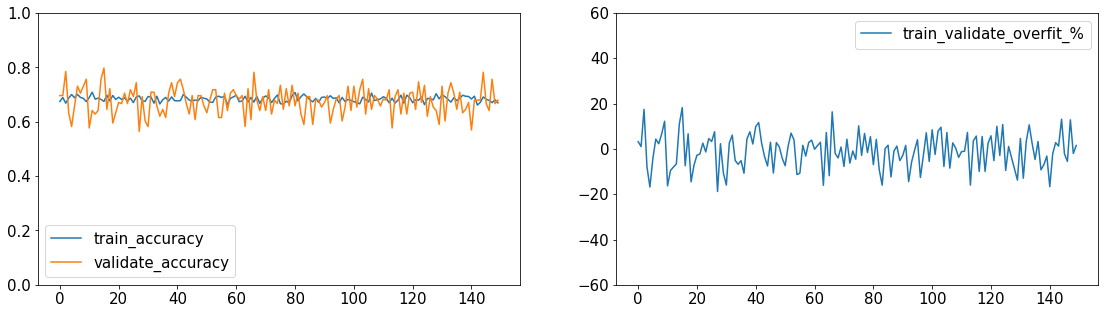

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_accuracy'], label='train_accuracy')
ax[0].plot(temp_df['validate_accuracy'], label='validate_accuracy')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

# <font color=blue>Recall  

In [12]:
temp_df = zip(train_recall, validate_recall)
temp_df = pd.DataFrame(temp_df, columns=['train_recall', 'validate_recall'])
temp_df['overfit_%'] = (temp_df['validate_recall']-temp_df['train_recall'])/temp_df['train_recall']*100
temp_df

,train_recall,validate_recall,overfit_%
0,0.817568,1.000000,22.314050
1,0.810811,0.909091,12.121212
2,0.824324,1.000000,21.311475
3,0.817568,0.727273,-11.044328
4,0.831081,0.454545,-45.306726
...,...,...,...
145,0.825503,0.900000,9.024390
146,0.818792,0.900000,9.918033
147,0.824324,0.909091,10.283159
148,0.824324,0.727273,-11.773472


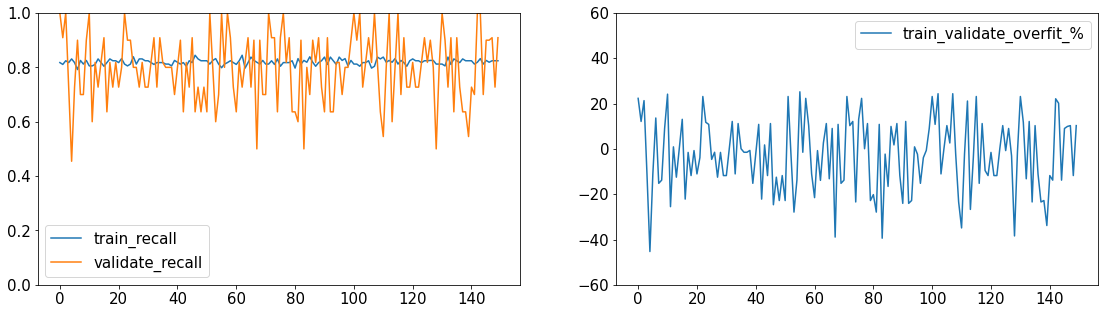

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_recall'], label='train_recall')
ax[0].plot(temp_df['validate_recall'], label='validate_recall')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

# <font color=blue>Precision  

In [14]:
temp_df = zip(train_precision, validate_precision)
temp_df = pd.DataFrame(temp_df, columns=['train_precision', 'validate_precision'])
temp_df['overfit_%'] = (temp_df['validate_precision']-temp_df['train_precision'])/temp_df['train_precision']*100
temp_df

,train_precision,validate_precision,overfit_%
0,0.268293,0.314286,17.142857
1,0.277136,0.303030,9.343434
2,0.265217,0.392857,48.126464
3,0.276888,0.235294,-15.021877
4,0.288056,0.156250,-45.757114
...,...,...,...
145,0.275785,0.264706,-4.017217
146,0.272321,0.250000,-8.196721
147,0.266376,0.357143,34.074941
148,0.272931,0.258065,-5.446854


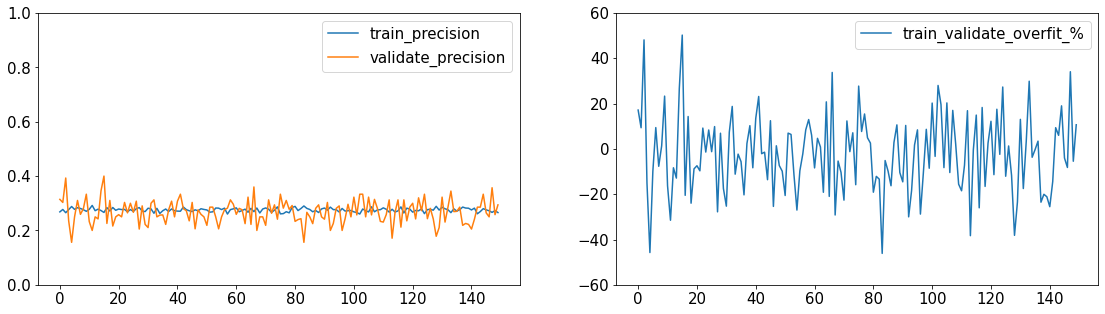

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_precision'], label='train_precision')
ax[0].plot(temp_df['validate_precision'], label='validate_precision')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

# <font color=blue>Full dataset model summary  

In [16]:
# ---------- impute ----------

knn_impute = KNNImputer(n_neighbors=5)
X_impute, knn_impute_fit_transform = impute_fit_transform(X, knn_impute)

# ---------- oversample ----------

o_s = SMOTE(random_state=42, sampling_strategy=oversample)
X_impute_over, y_over = o_s.fit_resample(X_impute, y.ravel())

# ---------- scale ----------

ss = StandardScaler()
X_impute_over_scale, ss_fit_transform = scale_fit_transform(X_impute_over, ss)

# ---------- instantiate and fit regularized ----------

X_impute_over_scale_const = sm.add_constant(X_impute_over_scale)
lr = sm.Logit(y_over, X_impute_over_scale_const)
lr_result = lr.fit_regularized(maxiter=500, method='l1', alpha=reg_alpha)

# ---------- model summary ----------

print('-------------------- Model Summary 1: From Statsmodels API --------------------')
print('')
print(lr_result.summary())
print('')

print('-------------------- Model Summary 2: Sorted by ascending p --------------------')
print('')
temp_df = pd.read_html(lr_result.summary().tables[1].as_html(), header=0, index_col=0)[0]
temp_df = pd.DataFrame(temp_df)
temp_df.reset_index(level=0, inplace=True)
temp_df.rename(columns={'index': 'feature', 'std err': 'std_err', 'P>|z|': 'p', 'coef': 'std_coef'}, inplace=True)
temp_df = temp_df[['feature', 'std_coef', 'z', 'p']]
temp_df.sort_values(by='p', ascending=True, inplace=True)
print(temp_df)
print('')

print('-------------------- Model Summary 3: p < 0.05 sorted by coef --------------------')
print('')
print(temp_df[temp_df['p']<0.05][['feature', 'std_coef', 'z', 'p']].sort_values(by='std_coef'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4996996412050061
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
-------------------- Model Summary 1: From Statsmodels API --------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1881
Model:                          Logit   Df Residuals:                     1870
Method:                           MLE   Df Model:                           10
Date:                Mon, 03 Jan 2022   Pseudo R-squ.:                  0.2756
Time:                        09:20:25   Log-Likelihood:                -939.94
converged:                       True   LL-Null:                       -1297.6
Covariance Type:            nonrobust   LLR p-value:                3.274e-147
                         coef    std err          z      P>|z|      [0.025   

# <font color=blue>Save model, impute fit_transform, and scale fit_transform  

In [17]:
#dump(knn_impute_fit_transform, open('impute_fit_transform.pkl', 'wb'))
dump(ss_fit_transform, open('scale_fit_transform.pkl', 'wb'))
dump(lr_result, open('model_log_reg_regz.pkl', 'wb'))

# <font color=blue>Load model and scale transform  

In [18]:
lrr_model = load(open('model_log_reg_regz.pkl', 'rb'))
#lrr_impute = load(open('impute_fit_transform.pkl', 'rb'))
lrr_scale = load(open('scale_fit_transform.pkl', 'rb'))

# <font color=blue>Test 1 - Predict from loaded model  

In [19]:
print(lrr_model.params)

const                -0.209988
renal_failure        -0.516615
bicarbonate          -0.387468
blood_calcium        -0.450769
urine_output         -0.428506
deficiencyanemias    -0.342815
sp_o2                -0.390122
heart_rate            0.302145
leucocyte             0.345446
atrialfibrillation    0.313349
urea_nitrogen         0.755791
dtype: float64


In [20]:
print(lrr_model.params.index[0])

const


In [21]:
print(lrr_model.params.values[0])

-0.2099884202398223


In [22]:
X_given = pd.DataFrame(columns=lrr_model.params.index)

In [23]:
# ---------- case one ----------

X_given.loc[0, 'const'] = lrr_model.params.values[0]
X_given.loc[0, 'bicarbonate'] = 42.75
X_given.loc[0, 'urine_output'] = 2300
X_given.loc[0, 'urea_nitrogen'] = 19.286
X_given.loc[0, 'leucocyte'] = 3.64
X_given.loc[0, 'blood_calcium'] = 9.22
X_given.loc[0, 'renal_failure'] = 0
X_given.loc[0, 'heart_rate'] = 98.54
X_given.loc[0, 'deficiencyanemias'] = 0
X_given.loc[0, 'atrialfibrillation'] = 0
X_given.loc[0, 'sp_o2'] = 89.11
print(X_given)
print('')

# ---------- scale ----------

X_given_scale = scale_transform(X_given.drop(columns=['const']), lrr_scale)
print('---------- X_given_scale ----------')
print('')
print(X_given_scale)
print('')

# ---------- predict ----------

X_given_scale['const'] = lrr_model.params.values[0]
y_predicted = (lrr_model.predict(X_given_scale)>=decision_boundary).astype(int)
print('---------- y_predicted case one ----------')
print('')
print('Predicted class using decision boundary of ', decision_boundary, ' :', y_predicted[0])
print('Predicted probability :', lrr_model.predict(X_given_scale)[0])

      const renal_failure bicarbonate blood_calcium urine_output  \
0 -0.209988             0       42.75          9.22         2300   

  deficiencyanemias  sp_o2 heart_rate leucocyte atrialfibrillation  \
0                 0  89.11      98.54      3.64                  0   

  urea_nitrogen  
0        19.286  

---------- X_given_scale ----------

   renal_failure  bicarbonate  blood_calcium  urine_output  deficiencyanemias  \
0      -0.727533     3.289887       1.431514      0.526063          -0.684095   

      sp_o2  heart_rate  leucocyte  atrialfibrillation  urea_nitrogen  
0 -2.798951    0.807947  -1.398505           -1.079525      -0.909481  

---------- y_predicted case one ----------

Predicted class using decision boundary of  0.35  : 0
Predicted probability : 0.06658759944273421


# <font color=blue>Test 2 - Predict from loaded model  

In [24]:
# ---------- case two ----------

X_given.loc[0, 'const'] = lrr_model.params.values[0]
X_given.loc[0, 'bicarbonate'] = 26.36
X_given.loc[0, 'urine_output'] = 1766
X_given.loc[0, 'urea_nitrogen'] = 32.73
X_given.loc[0, 'leucocyte'] = 4.84
X_given.loc[0, 'blood_calcium'] = 8.32
X_given.loc[0, 'renal_failure'] = 0
X_given.loc[0, 'heart_rate'] = 76.38
X_given.loc[0, 'deficiencyanemias'] = 0
X_given.loc[0, 'atrialfibrillation'] = 0
X_given.loc[0, 'sp_o2'] = 94.38
print(X_given)
print('')

# ---------- scale ----------

X_given_scale = scale_transform(X_given.drop(columns=['const']), lrr_scale)
print('---------- X_given_scale ----------')
print('')
print(X_given_scale)
print('')

# ---------- predict ----------

X_given_scale['const'] = lrr_model.params.values[0]
y_predicted = (lrr_model.predict(X_given_scale)>=decision_boundary).astype(int)
print('---------- y_predicted case one ----------')
print('')
print('Predicted class using decision boundary of ', decision_boundary, ' :', y_predicted[0])
print('Predicted probability :', lrr_model.predict(X_given_scale)[0])

      const renal_failure bicarbonate blood_calcium urine_output  \
0 -0.209988             0       26.36          8.32         1766   

  deficiencyanemias  sp_o2 heart_rate leucocyte atrialfibrillation  \
0                 0  94.38      76.38      4.84                  0   

  urea_nitrogen  
0         32.73  

---------- X_given_scale ----------

   renal_failure  bicarbonate  blood_calcium  urine_output  deficiencyanemias  \
0      -0.727533     0.103511      -0.166899      0.085838          -0.684095   

      sp_o2  heart_rate  leucocyte  atrialfibrillation  urea_nitrogen  
0 -0.685757   -0.671715  -1.191014           -1.079525      -0.326502  

---------- y_predicted case one ----------

Predicted class using decision boundary of  0.35  : 1
Predicted probability : 0.4804496118558467
